In [1]:
import pandas as pd
import numpy as np

sesion_path = 'OpenMATB\\sessions\\2024-01-09\\Session 19\\19_240109_183806.csv'
data = pd.read_csv(sesion_path)
read_data = data[data.apply(lambda row: row.astype(str).str.contains('performance', case=False).any(), axis=1)]
output_file_path = sesion_path.replace('.csv', '_performance.csv')
read_data.to_csv(output_file_path, index=False)
print(read_data.head(10))


      logtime  scenario_time         type  module           address value
156  4.281453       0.228015  performance  resman    a_in_tolerance     1
157  4.281556       0.228015  performance  resman       a_deviation     0
158  4.281601       0.228015  performance  resman    b_in_tolerance     1
159  4.281645       0.228015  performance  resman       b_deviation     0
170  4.299671       0.228015  performance   track        joystick_x     0
171  4.299717       0.228015  performance   track        joystick_y     0
194  4.320936       0.267334  performance   track        joystick_x     0
195  4.320971       0.267334  performance   track        joystick_y     0
196  4.321043       0.267334  performance   track  cursor_in_target     1
197  4.321087       0.267334  performance   track  center_deviation   0.0


In [4]:
import os
from glob import glob
import pandas as pd
PATH = "OpenMATB\\sessions\\2024-01-09\\Session 19"
EXT = "*.csv"
all_csv_files = [file
                 for path, subdir, files in os.walk(PATH)
                 for file in glob(os.path.join(path, EXT))]
dfs = []
for file in all_csv_files:
    if "performance" in file:
        df = pd.read_csv(file)
        dfs.append(df)
for df in dfs:
    df['cumulative_time'] = 0
dfs[0]['cumulative_time'] = dfs[0]['scenario_time']
for i in range(0, len(dfs)):
    if i + 1 < len(dfs):
        dfs[i+1]['cumulative_time'] = dfs[i+1]['scenario_time']+dfs[i].tail(1)['cumulative_time'].values[0]
performance_data = pd.concat(dfs, join='inner',ignore_index=True)
print(performance_data.tail(10))

          logtime  scenario_time         type module           address  \
23126  303.951626     299.898044  performance  track  cursor_in_target   
23127  303.951741     299.898044  performance  track  center_deviation   
23128  303.985024     299.931439  performance  track  cursor_in_target   
23129  303.985162     299.931439  performance  track  center_deviation   
23130  304.018456     299.964773  performance  track  cursor_in_target   
23131  304.018587     299.964773  performance  track  center_deviation   
23132  304.051616     299.998026  performance  track  cursor_in_target   
23133  304.051740     299.998026  performance  track  center_deviation   
23134  304.084969     300.031380  performance  track  cursor_in_target   
23135  304.085095     300.031380  performance  track  center_deviation   

          value  cumulative_time  
23126         1       299.898044  
23127  1.320671       299.898044  
23128         1       299.931439  
23129  1.541058       299.931439  
23130     

## Track - sekcija

In [5]:
from sklearn.model_selection import train_test_split
track_data = performance_data[
    performance_data.apply(
        lambda row: row.astype(str).str.contains('track', case=False).any() and 
                    row.astype(str).str.contains('center_deviation', case=False).any(),
        axis=1
    )
]

track_data['value'] = pd.to_numeric(track_data['value'], errors='coerce')
numeric_columns = track_data.select_dtypes(include='number').columns.tolist()
track_data_encoded = track_data[numeric_columns].drop(['scenario_time','logtime'], axis=1)
print(track_data_encoded)


          value  cumulative_time
9      0.000000         0.267334
13     1.943399         0.325491
15     2.915022         0.350782
17     2.481451         0.385101
19     2.057138         0.418391
...         ...              ...
23127  1.320671       299.898044
23129  1.541058       299.931439
23131  0.842325       299.964773
23133  0.303159       299.998026
23135  1.270828       300.031380

[8999 rows x 2 columns]


C:\Users\grado\AppData\Local\Temp\ipykernel_27780\163824420.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_data['value'] = pd.to_numeric(track_data['value'], errors='coerce')


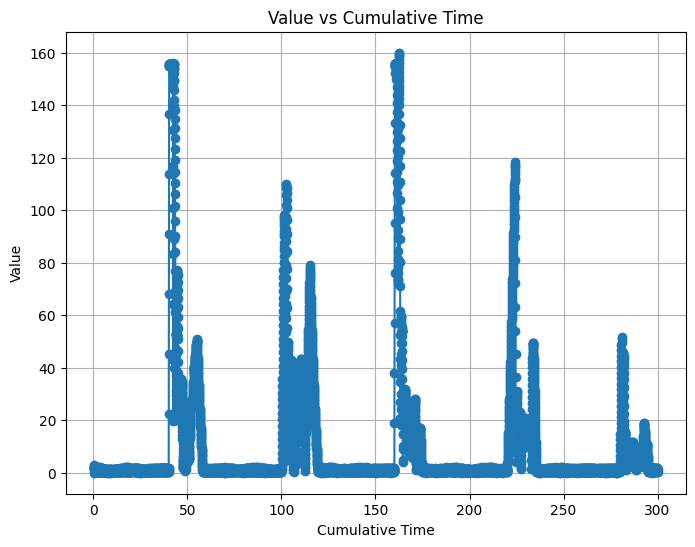

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(track_data_encoded['cumulative_time'], track_data_encoded['value'], marker='o', linestyle='-')
plt.xlabel('Cumulative Time')
plt.ylabel('Value')
plt.title('Value vs Cumulative Time')
plt.grid(True)
plt.show()

In [7]:
y_track = track_data_encoded['value'].values
X_track = track_data_encoded.drop(columns=['value'])
X_train, X_test, y_train, y_test = train_test_split(X_track, y_track, test_size=0.2, shuffle=False)

In [50]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_absolute_error
from keras.optimizers import Adam
import keras as keras
import numpy as np

time_steps = 256
X_train_sequence = []
y_train_sequence = []
for i in range(len(X_train) - time_steps):
    X_train_sequence.append(X_train.iloc[i:i+time_steps].values)
    y_train_sequence.append(y_train[i+time_steps])
X_train_sequence = np.array(X_train_sequence)
y_train_sequence = np.array(y_train_sequence)
y_train_sequence = np.asarray(y_train_sequence).astype(np.float32)
model = Sequential()
model.add(LSTM(units=256, return_sequences=True, input_shape=(X_train_sequence.shape[1], X_train_sequence.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=512, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(64))
model.add(Dense(1))
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='mean_squared_error')
model.fit(X_train_sequence, y_train_sequence, epochs=20, batch_size=64)





Epoch 1/20
109/109 [==============================] - 21s 173ms/step - loss: 720.3169
Epoch 2/20
109/109 [==============================] - 19s 175ms/step - loss: 668.1689
Epoch 3/20
109/109 [==============================] - 19s 175ms/step - loss: 635.5024
Epoch 4/20
109/109 [==============================] - 19s 176ms/step - loss: 601.0847
Epoch 5/20
109/109 [==============================] - 19s 179ms/step - loss: 567.4903
Epoch 6/20
109/109 [==============================] - 20s 182ms/step - loss: 578.7037
Epoch 7/20
109/109 [==============================] - 20s 185ms/step - loss: 566.6119
Epoch 8/20
109/109 [==============================] - 20s 185ms/step - loss: 536.8530
Epoch 9/20
109/109 [==============================] - 20s 185ms/step - loss: 542.1923
Epoch 10/20
109/109 [==============================] - 20s 186ms/step - loss: 559.1858
Epoch 11/20
109/109 [==============================] - 20s 186ms/step - loss: 496.0210
Epoch 12/20
109/109 [==============================]

In [52]:
X_test_sequence = []
y_test_sequence = []
for i in range(len(X_test) - time_steps):
    X_test_sequence.append(X_test.iloc[i:i+time_steps].values)
    y_test_sequence.append(y_test[i+time_steps])

X_test_sequence = np.array(X_test_sequence)
y_test_sequence = np.array(y_test_sequence)
X_test_sequence = np.reshape(X_test_sequence, (X_test_sequence.shape[0], X_test_sequence.shape[1], X_test_sequence.shape[2]))

y_pred = model.predict(X_test_sequence)
mae = mean_absolute_error(y_test_sequence, y_pred)
print("Mean Absolute Error (MAE) on test set:", mae)

49/49 [==============================] - 2s 50ms/step
Mean Absolute Error (MAE) on test set: 10.40918370100312


## Resman - sekcija

In [53]:
def handle_non_numerical_data(df):
    columns = df.columns.values
    for column in columns:
        text_digit_vals = {}
        def convert_to_int(val):
            return text_digit_vals[val]

        if df[column].dtype != np.int64 and df[column].dtype != np.float64:
            column_contents = df[column].values.tolist()
            unique_elements = set(column_contents)
            x = 0
            for unique in unique_elements:
                if unique not in text_digit_vals:
                    text_digit_vals[unique] = x
                    x+=1

            df[column] = list(map(convert_to_int, df[column]))

    return df

In [54]:
resman_data = performance_data[
    performance_data.apply(
        lambda row: row.astype(str).str.contains('resman', case=False).any() and 
                    row.astype(str).str.contains('a_deviation', case=False).any() or row.astype(str).str.contains('b_deviation', case=False).any(),
        axis=1
    )
]

resman_data['value'] = pd.to_numeric(resman_data['value'], errors='coerce')
resman_data = handle_non_numerical_data(resman_data)
numeric_columns = resman_data.select_dtypes(include='number').columns.tolist()
resman_data_encoded = resman_data[numeric_columns].drop(['scenario_time','logtime','type','module'], axis=1)
print(resman_data_encoded)

       address  value  cumulative_time
1            1      0         0.228015
3            0      0         0.228015
129          1    -26         2.233965
131          0    -26         2.233965
255          1    -52         4.250221
...        ...    ...              ...
22757        0    372       294.433303
22913        1    212       296.449258
22915        0    392       296.449258
23039        1    232       298.465310
23041        0    412       298.465310

[298 rows x 3 columns]


C:\Users\grado\AppData\Local\Temp\ipykernel_27780\2319845938.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  resman_data['value'] = pd.to_numeric(resman_data['value'], errors='coerce')
C:\Users\grado\AppData\Local\Temp\ipykernel_27780\33590573.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = list(map(convert_to_int, df[column]))


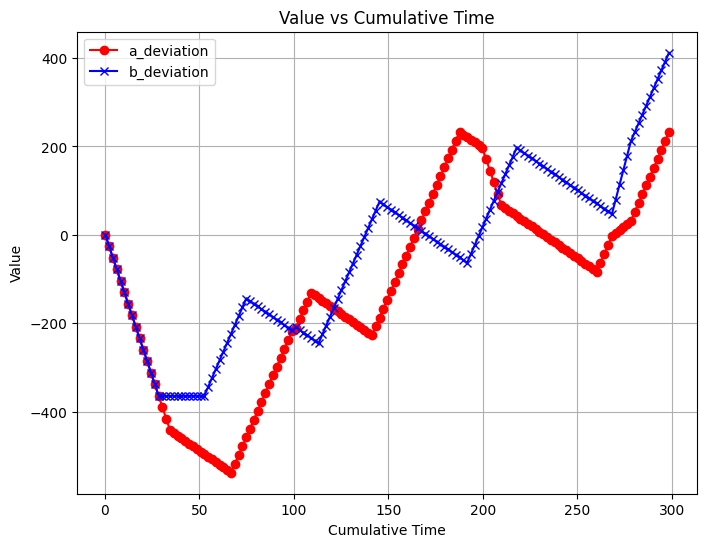

In [64]:
data_address_1 = resman_data_encoded[resman_data_encoded['address'] == 1]
data_address_0 = resman_data_encoded[resman_data_encoded['address'] == 0]
plt.figure(figsize=(8, 6))
plt.plot(data_address_1['cumulative_time'], data_address_1['value'], marker='o', linestyle='-', color='red', label='a_deviation')
plt.plot(data_address_0['cumulative_time'], data_address_0['value'], marker='x', linestyle='-', color='blue', label='b_deviation')
plt.xlabel('Cumulative Time')
plt.ylabel('Value')
plt.title('Value vs Cumulative Time')
plt.legend()
plt.grid(True)
plt.show()



In [56]:
y_resman = resman_data_encoded['value'].values
X_resman = resman_data_encoded.drop(columns=['value'])
X_train_resman, X_test_resman, y_train_resman, y_test_resman = train_test_split(X_resman, y_resman, test_size=0.3, shuffle=False)

In [58]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_absolute_error
from keras.optimizers import Adam
import keras as keras

time_steps = 64
X_train_sequence_resman = []
y_train_sequence_resman = []
for i in range(len(X_train_resman) - time_steps):
    X_train_sequence_resman.append(X_train_resman.iloc[i:i+time_steps].values)
    y_train_sequence_resman.append(y_train_resman[i+time_steps])

X_train_sequence_resman = np.array(X_train_sequence_resman)
y_train_sequence_resman = np.array(y_train_sequence_resman)
y_train_sequence_resman = np.asarray(y_train_sequence_resman).astype(np.float32)
model_resman = Sequential()
model_resman.add(LSTM(units=64, return_sequences=True, input_shape=(X_train_sequence_resman.shape[1], X_train_sequence_resman.shape[2])))
model_resman.add(Dropout(0.2))
model_resman.add(LSTM(128, return_sequences=False))
model_resman.add(Dropout(0.2))
model_resman.add(Dense(32))
model_resman.add(Dense(1))
optimizer = Adam(lr=0.0001)

model_resman.compile(optimizer=optimizer, loss='mean_squared_error')
model_resman.fit(X_train_sequence_resman, y_train_sequence_resman, epochs=500, batch_size=32)



Epoch 1/500
5/5 [==============================] - 3s 55ms/step - loss: 38866.1484
Epoch 2/500
5/5 [==============================] - 0s 25ms/step - loss: 38787.8477
Epoch 3/500
5/5 [==============================] - 0s 14ms/step - loss: 38699.6328
Epoch 4/500
5/5 [==============================] - 0s 19ms/step - loss: 38623.1211
Epoch 5/500
5/5 [==============================] - 0s 12ms/step - loss: 38490.7539
Epoch 6/500
5/5 [==============================] - 0s 13ms/step - loss: 38399.3477
Epoch 7/500
5/5 [==============================] - 0s 14ms/step - loss: 38253.2383
Epoch 8/500
5/5 [==============================] - 0s 12ms/step - loss: 38098.1289
Epoch 9/500
5/5 [==============================] - 0s 18ms/step - loss: 37940.0156
Epoch 10/500
5/5 [==============================] - 0s 13ms/step - loss: 37773.3203
Epoch 11/500
5/5 [==============================] - 0s 18ms/step - loss: 37582.8555
Epoch 12/500
5/5 [==============================] - 0s 13ms/step - loss: 37446.8594
E

In [59]:
print(X_test_resman.shape)
X_test_sequence_resman = []
y_test_sequence_resman = []
for i in range(len(X_test_resman) - time_steps):
    X_test_sequence_resman.append(X_test_resman.iloc[i:i+time_steps].values)
    y_test_sequence_resman.append(y_test_resman[i+time_steps])

X_test_sequence_resman = np.array(X_test_sequence_resman)
y_test_sequence_resman = np.array(y_test_sequence_resman)
X_test_sequence_resman = np.reshape(X_test_sequence_resman, (X_test_sequence_resman.shape[0], X_test_sequence_resman.shape[1], X_test_sequence_resman.shape[2]))

y_pred_resman = model_resman.predict(X_test_sequence_resman)
mae_resman = mean_absolute_error(y_test_sequence_resman, y_pred_resman)
print("Mean Absolute Error (MAE) on test set:", mae_resman)

(90, 2)
1/1 [==============================] - 1s 824ms/step
Mean Absolute Error (MAE) on test set: 128.57234896146335
